# 1. Данный код предполагает реализацию модели по предсказанию типа обращения (классификация обращений на запросы и инциденты).
# 2. Для бизнеса инцидент это более критичное событие, нежели запрос, поэтому необходимо выявлять тенденции происхождения аномалий.
# 3. Для решения задачи №1 использовались инструменты  tf-idf + logreg (работает быстро и в оффлайне)
# 4. Так же в процессе пробовали реализацию с использованием берт, но он дольше дает результаты (однако его результаты немного лучше) + у него проблемы с интерпретарцией

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
sample_submission = pd.read_csv('submission.csv')

In [6]:
TYPE_DICT = {'Запрос': 0, 'Инцидент': 1}

In [7]:
# препроцессинг фичей с датами

def preprocess(df, is_train=True):
    df = df.copy()
    
    df['Дата закрытия обращения'] = pd.to_datetime(df['Дата закрытия обращения'])
    df['Дата обращения'] = pd.to_datetime(df['Дата обращения'])

    df['open_date'] = df['Дата обращения'].dt.date
    df['close_date'] = df['Дата закрытия обращения'].dt.date
    
    if is_train:
        df['Тип обращения итоговый'] = df['Тип обращения итоговый'].map(TYPE_DICT)
    
    return df

In [8]:
train = preprocess(train)
test = preprocess(test, False)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, train['Тип обращения итоговый'], random_state=42)

# Начнем с базовой модельки без учета времени

In [10]:
# tf-idf
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [11]:
# обучаем лог реги и предсказываем вероятность инцидента (порог выбрали = 0.35) и если вероятность больше порога, считаем ее инцидентом

tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), y_train)

print(classification_report(y_test, 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

/var/folders/b7/g3pfszns5rgb692n3xkgmhz80000gn/T/ipykernel_30440/4261361024.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
/Users/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/b7/g3pfszns5rgb692n3xkgmhz80000gn/T/ipykernel_30440/4261361024.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  X_test['Содержание'].fillna('NO DATA').str.repla

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3594
           1       0.76      0.65      0.70       107

    accuracy                           0.98      3701
   macro avg       0.88      0.82      0.85      3701
weighted avg       0.98      0.98      0.98      3701



In [214]:
# модель на тех же фичах, но таргет уже тип переклассификации

tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**3, max_iter=500)

In [215]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип переклассификации'])

print(classification_report(X_test['Тип переклассификации'], 
                            logreg.predict(tf_idf.transform(X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))))

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3611
           1       0.84      0.60      0.70        35
           2       0.68      0.69      0.68        55

    accuracy                           0.99      3701
   macro avg       0.84      0.76      0.79      3701
weighted avg       0.99      0.99      0.99      3701



# Учтем время

In [240]:
train['Дата обращения'].min(), train['Дата обращения'].max()

(Timestamp('2018-01-19 09:27:00'), Timestamp('2018-02-16 13:10:00'))

In [241]:
X_train, X_test = (train[train['Дата обращения'] < pd.to_datetime('2018-02-01 00:00:00')], 
                  train[train['Дата обращения'] >= pd.to_datetime('2018-02-01 00:00:00')])

In [242]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [243]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип обращения итоговый'])

print(classification_report(X_test['Тип обращения итоговый'], 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10546
           1       0.39      0.50      0.44       305

    accuracy                           0.96     10851
   macro avg       0.69      0.74      0.71     10851
weighted avg       0.97      0.96      0.97     10851



In [244]:
# отдельный столбец с вероятностью того, что запись является инцидентом
X_test['prob'] = logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]

/var/folders/9g/wztsgzvn6pb5m65md8hxmdrc0000gp/T/ipykernel_61841/3417248553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prob'] = logreg.predict_proba(tf_idf.transform(


In [245]:
# округляем даты обращений до 3 часов и рассматриваем их как единицу потенциальных аномалий
X_test['start_date_round'] = X_test['Дата обращения'].dt.round("3H")

/var/folders/9g/wztsgzvn6pb5m65md8hxmdrc0000gp/T/ipykernel_61841/3551685744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['start_date_round'] = X_test['Дата обращения'].dt.round("3H")


# Посмотрим на ряд вероятностей инцидентов во времени

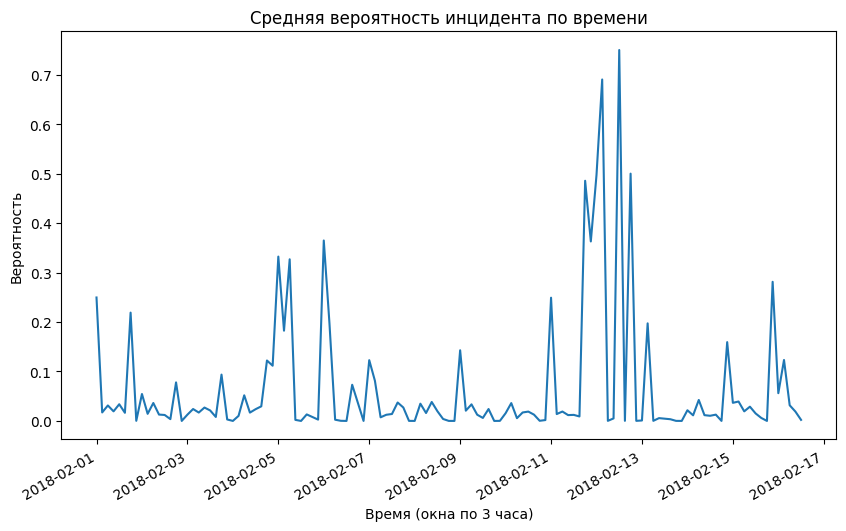

In [239]:
X_test.groupby(by='start_date_round')['prob'].mean().plot(figsize=(10, 6));
plt.title("Средняя вероятность инцидента по времени")
plt.ylabel("Вероятность")
plt.xlabel("Время (окна по 3 часа)");

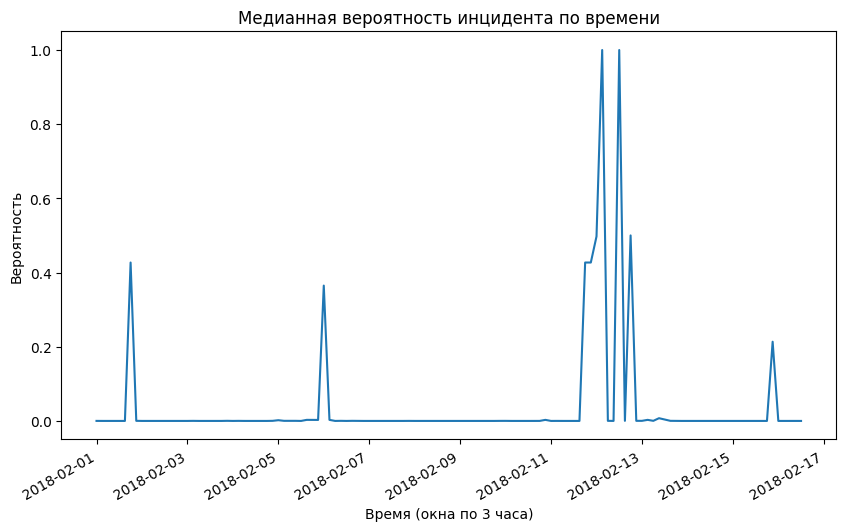

In [235]:
X_test.groupby(by='start_date_round')['prob'].median().plot(figsize=(10, 6));
plt.title("Медианная вероятность инцидента по времени")
plt.ylabel("Вероятность")
plt.xlabel("Время (окна по 3 часа)");

# Попробуем сделать кластеризацию, чтобы выделить основные кластеры

In [246]:
tf_idf = TfidfVectorizer(analyzer='word', max_features=5000)

In [247]:
cluster_inerias = []
train_data = tf_idf.fit_transform(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

for n in range(2, 30):
    mb_kmeans = MiniBatchKMeans(n_clusters=n)
    mb_kmeans.fit(train_data)
    cluster_inerias.append(mb_kmeans.inertia_)

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


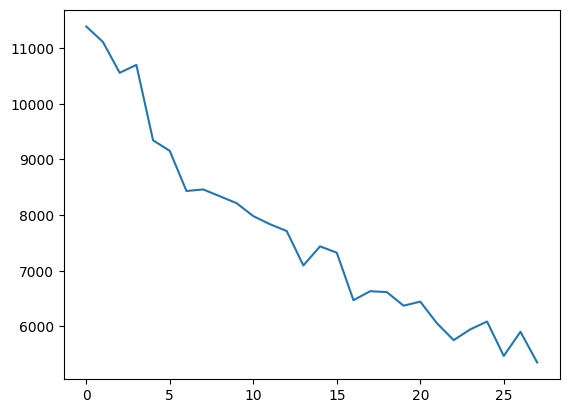

In [249]:
# используем метод локтя для определения оптимального количества кластеров для разбиения = берем 10
plt.plot(cluster_inerias);

In [ ]:
mb_kmeans = MiniBatchKMeans(n_clusters=10)

train['cluster'] = mb_kmeans.fit_predict(train_data)

In [251]:
train['cluster'].value_counts()

cluster
2    6131
0    3140
9    1280
4    1080
8    1025
6     596
3     529
1     391
7     370
5     261
Name: count, dtype: int64

In [252]:
train.groupby(['cluster'])['Тип обращения итоговый'].mean()

cluster
0    0.000000
1    0.319693
2    0.045180
3    0.000000
4    0.000926
5    0.000000
6    0.000000
7    0.002703
8    0.000976
9    0.000000
Name: Тип обращения итоговый, dtype: float64

Cluster 0:


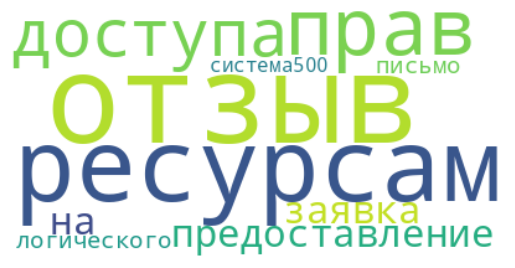

Cluster 1:


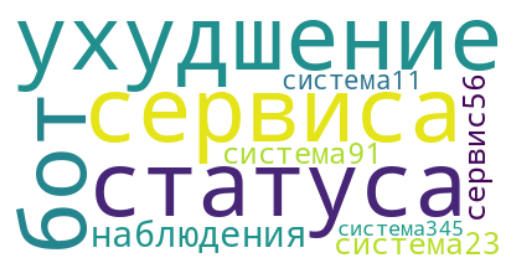

Cluster 2:


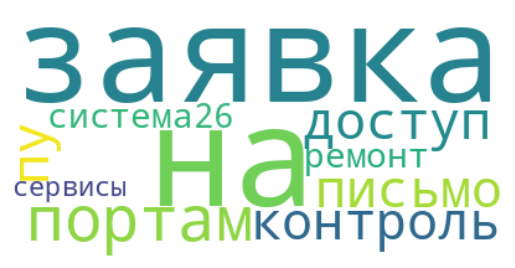

Cluster 3:


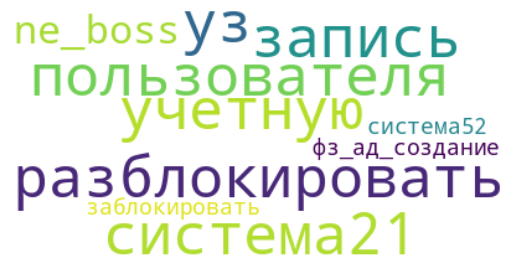

Cluster 4:


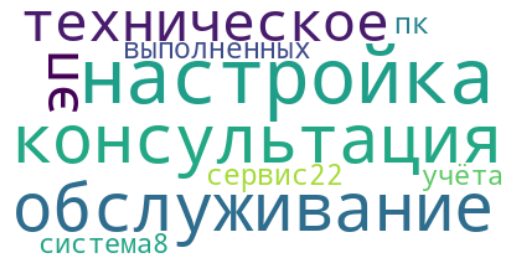

Cluster 5:


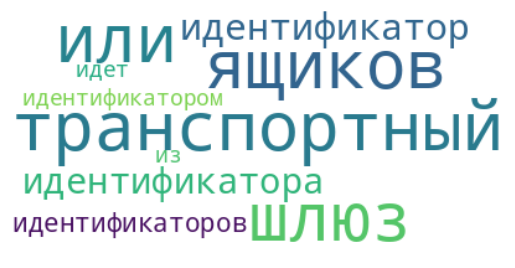

Cluster 6:


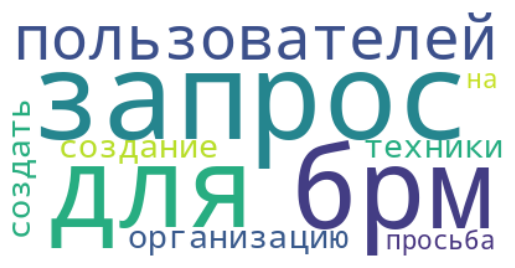

Cluster 7:


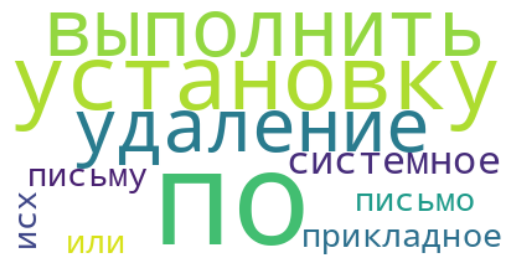

Cluster 8:


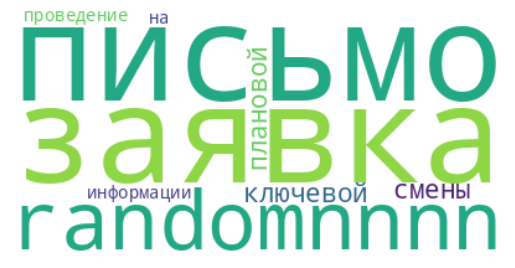

Cluster 9:


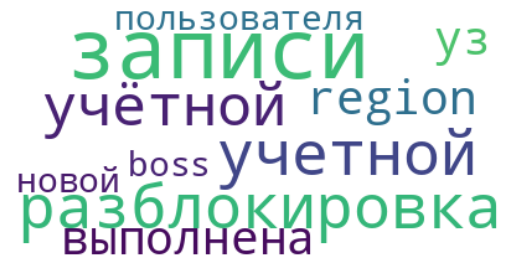

In [253]:
from wordcloud import WordCloud
order_centroids = mb_kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf.get_feature_names_out()

for i in range(10):
    print(f"Cluster {i}:")
    words = [terms[ind] for ind in order_centroids[i, :10]]
    wc = WordCloud(background_color="white", max_words=10).generate(" ".join(words))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [254]:
# Посмотрим на 1 кластер, где в основном сгруппировались инциденты
train[train['cluster'] == 1][:10]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster
59,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 07:51,2018-01-26 03:43:00,Запрос,0,Поток *********** отработал штатно.,0,2018-01-26 04:51,2018-02-02 07:52:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,1
152,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 07:52,2018-01-26 06:42:00,Запрос,0,Поток ********* завершен успешно,0,2018-01-26 08:28,2018-02-02 09:44:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,1
353,<Бот-наблюдения> Система11. Ухудшение статуса ...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-01-31 09:36,2018-01-26 08:21:00,Запрос,0,"временная нагрузка. очереди сообщений нет, соб...",0,2018-01-26 08:54,2018-02-02 10:13:00,4-Нет,3-Малое,Система11,Место1,2018-01-26,2018-02-02,1
378,<Бот-наблюдения> Сервис56. Ухудшение статуса с...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 09:55,2018-01-26 08:45:00,Запрос,0,Abort выполнялся в рамках **********,0,2018-01-26 09:22,2018-02-02 10:38:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,1
404,<Бот-наблюдения> Система368. Ухудшение статуса...,Сервис320,3-Низкий,Закрыт,ФГ56,2018-01-31 10:08,2018-01-26 08:58:00,Запрос,0,Самовосстановление,0,2018-01-26 09:22,2018-02-02 10:38:00,2-Повышенная,3-Малое,Система368,Место1,2018-01-26,2018-02-02,1
469,<Бот-наблюдения> Сервис56. Ухудшение статуса с...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 10:55,2018-01-26 09:45:00,Запрос,0,Abort выполнялся в рамках **********,0,2018-01-26 10:32,2018-02-02 11:49:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,1
758,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-27 13:48,2018-01-26 14:48:00,Запрос,0,Поток ********* завершен успешно,0,2018-01-26 15:03,2018-02-03 07:23:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,1
849,<Бот-наблюдения> Система11. Ухудшение статуса ...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-02-01 07:51,2018-01-26 15:51:00,Запрос,0,Выполнена проверка почтовых очередей Система11...,0,2018-01-26 22:22,2018-02-03 07:52:00,4-Нет,3-Малое,Система11,Место1,2018-01-26,2018-02-03,1
878,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ201,2018-01-27 10:36,2018-01-26 17:18:00,Запрос,0,Замедления загрузок данных средствами Система5...,0,2018-01-27 11:27,2018-02-03 12:43:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,1
879,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ201,2018-01-27 10:36,2018-01-26 17:24:00,Запрос,0,Замедления загрузок данных средствами Система5...,0,2018-01-27 11:29,2018-02-03 12:49:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,1


## Видим, что у нас реально есть кластера, на которые важнее обращать внимание при оценке инцидентов

# Итоговое обучение модели


In [ ]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg_obrasheniya = LogisticRegression(C=10**4, max_iter=500)
logreg_pereclassification = LogisticRegression(C=10**4, max_iter=500)

tf_idf.fit(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

logreg_obrasheniya.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип обращения итоговый'])
logreg_pereclassification.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип переклассификации'])


preds_pereclassification = logreg_pereclassification.predict(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))

preds_obrasheniya = (logreg_obrasheniya.predict_proba(tf_idf.transform(
                                test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)

sample_submission["Тип переклассификации"] = preds_pereclassification
sample_submission["Тип обращения итоговый"] = preds_obrasheniya
sample_submission["Тип обращения итоговый"] = sample_submission["Тип обращения итоговый"].map(dict((v, k) for k, v in TYPE_DICT.items()))

In [259]:
# распределение на трейне
train["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
0    0.972641
1    0.027359
Name: proportion, dtype: float64

In [260]:
# распределение на тесте
sample_submission["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
Запрос      0.980927
Инцидент    0.019073
Name: proportion, dtype: float64

In [261]:
# # распределение на трейне
train["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.975816
2    0.014727
1    0.009458
Name: proportion, dtype: float64

In [262]:
# # распределение на тесте
sample_submission["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.980927
2    0.013871
1    0.005202
Name: proportion, dtype: float64

In [263]:
sample_submission.to_csv("final_submission.csv", index=None)

# Подсчет аномалий

In [264]:
train["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(train['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
test["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
train['start_date_round'] = train['Дата обращения'].dt.round("3H")
test["start_date_round"] = test['Дата обращения'].dt.round("3H")

In [265]:
train[["prob", "start_date_round"]]

,prob,start_date_round
0,8.306628e-01,2018-01-19 09:00:00
1,5.378598e-03,2018-01-19 09:00:00
2,1.935669e-10,2018-01-26 00:00:00
3,9.804415e-01,2018-01-26 00:00:00
4,1.386973e-04,2018-01-26 00:00:00
...,...,...
14798,1.539394e-07,2018-02-16 12:00:00
14799,6.236045e-14,2018-02-16 12:00:00
14800,2.950615e-09,2018-02-16 12:00:00
14801,1.183335e-06,2018-02-16 12:00:00


In [266]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))
def calculate_anomalies(ts, metric, factor, title="Аномалии", ylabel="Количество обращений"):
    
    df_ = ts.copy()
    df_rolling_stats = (
        df_[metric]
        .rolling(
            window=49,
            center=True,
            min_periods=2,
        )
        .agg({"rolling_mean": "mean", "rolling_std": "std"})
    )
    df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

    df_["is_anomaly"] = np.abs(df_[metric] - df_["rolling_mean"]) > factor * df_["rolling_std"]
    df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
    df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]
    _, ax = plt.subplots(figsize=[10, 5])
    df_.plot(y=[metric, "rolling_mean"], marker=".", ax=ax)
    df_.plot(
        y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
    )
    if df_["is_anomaly"].any():
        df_[metric].loc[df_["is_anomaly"]].plot(
            marker="o", color="r", ax=ax, legend=None, linestyle=""
        )
        
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")

    return df_[df_["is_anomaly"] == True].index


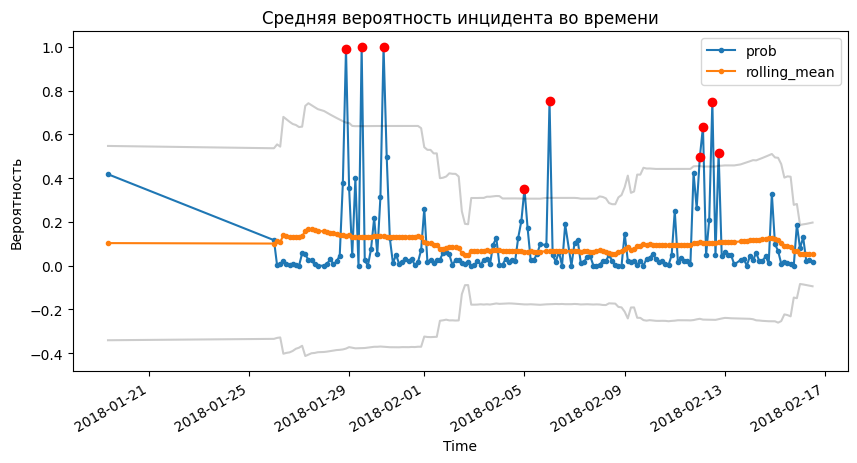

In [267]:
ts_train = train.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_train = calculate_anomalies(ts_train, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");
# 9 инцидентов на трейне

# Можно посмотреть на конкретные даты

In [185]:
anomaly_dates_probs_train

DatetimeIndex(['2018-01-28 21:00:00', '2018-01-29 12:00:00',
               '2018-01-30 09:00:00', '2018-02-05 00:00:00',
               '2018-02-06 00:00:00', '2018-02-12 00:00:00',
               '2018-02-12 03:00:00', '2018-02-12 12:00:00',
               '2018-02-12 18:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [142]:
train[train["start_date_round"] == "2018-02-12 12:00:00"]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster,prob,start_date_round
12447,Система26,Сервис26,2-Средний,Закрыт,ФГ154,2018-02-17 06:36,2018-02-12 11:04:00,Запрос,0,"Добрый день. РК удалена, проект возвращён испо...",...,2018-02-21 07:51:00,1-Особая,3-Малое,Система26,Место97,2018-02-12,2018-02-21,0,7.804929e-14,2018-02-12 12:00:00
12448,<Бот-наблюдения> Система57 Система91. Ухудшени...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:44,2018-02-12 12:44:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,1.000000e+00,2018-02-12 12:00:00
12449,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00
12450,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00


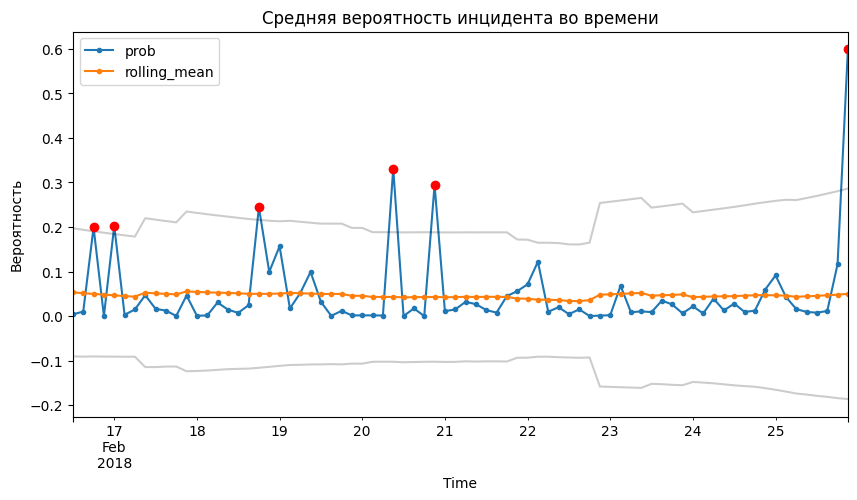

In [131]:
ts_test = test.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_test = calculate_anomalies(ts_test, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");

In [137]:

anomaly_dates_probs_test

DatetimeIndex(['2018-02-16 18:00:00', '2018-02-17 00:00:00',
               '2018-02-18 18:00:00', '2018-02-20 09:00:00',
               '2018-02-20 21:00:00', '2018-02-25 21:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [192]:
# По нашей оценке, в данном случае, мы задетектили ложный инцидент. Поэтому итоговое количество инцидентов на тесте - 5
test[test["start_date_round"] == "2018-02-20 09:00:00"]

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,...,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,prob,start_date_round
1940,16743,При выполнении Оператором НСИ пункта 8.3 Плана,Сервис240,3-Низкий,Закрыт,ФГ19,2018-02-23 08:36,2018-02-20 08:48:00,Инцидент,NaN,...,2018-02-20 10:12,2018-03-07 07:54:00,4-Нет,3-Малое,Система228,Место1,2018-02-20,2018-03-07,6.617320e-01,2018-02-20 09:00:00
1941,16744,Дистанционные курсы/тесты,Сервис36,3-Низкий,Отменен,ФГ47,2018-02-24 06:36,2018-02-20 09:48:00,Запрос,NaN,...,2018-02-20 11:54,NaT,4-Нет,4-Нет влияния,Система38,Место135,2018-02-20,NaT,3.391000e-08,2018-02-20 09:00:00
